<a href="https://colab.research.google.com/github/annabellegrimes/CPEN-400Q/blob/main/QGAN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[Quantum Generative Adversarial Networks with Cirq + TensorFlow](https://pennylane.ai/qml/demos/tutorial_QGAN.html)

We begin by importing PennyLane, NumPy, and TensorFlow.

In [ ]:
# install packages
!pip install pennylane
!pip install tensorflow
!pip install cirq
!pip install pennylane-cirq

     |████████████████████████████████| 800 kB 3.2 MB/s 
     |████████████████████████████████| 7.8 MB 14.3 MB/s 
     |████████████████████████████████| 1.6 MB 27.4 MB/s 
     |████████████████████████████████| 108 kB 39.4 MB/s 
     |████████████████████████████████| 462 kB 3.8 MB/s 
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 1.6 MB 7.7 MB/s 
     |████████████████████████████████| 47 kB 4.0 MB/s 
     |████████████████████████████████| 437 kB 57.3 MB/s 
     |████████████████████████████████| 328 kB 36.5 MB/s 
     |████████████████████████████████| 52 kB 968 kB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 97 kB 4.9 MB/s 
     |████████████████████████████████| 49 kB 3.8 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 145 kB 59.7 MB/s 
     |████████████████████████████████| 220 kB 33.2 MB/s 
     |█████████████████████████

In [ ]:
# This is needed so that the plotted figures appear embedded in this notebook
%matplotlib inline

# imports
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import cirq
import matplotlib.pyplot as plt

In [ ]:
# create a device
dev = qml.device('cirq.simulator', wires=3)

# Generator and Discriminator
For this simple example, our real data will be a qubit that has been rotated (from the starting state |0>) to some arbitrary, but fixed, state.

In [ ]:
def real(angles, **kwargs):
  qml.Hadamard(wires=0)
  qml.Rot(*angles, wires=0)

Both the real data circuit and the generator will output on wire 0, which will be connected as an input to the discriminator. Wire 1 is provided as a workspace for the generator, while the discriminator's output will be on wire 2.

In [ ]:
def generator(w, **kwargs):
  qml.Hadamard(wires=0)
  qml.RX(w[0], wires=0)
  qml.RX(w[1], wires=1)
  qml.RY(w[2], wires=0)
  qml.RY(w[3], wires=1)
  qml.RZ(w[4], wires=0)
  qml.RZ(w[5], wires=1)
  qml.CNOT(wires=[0, 1])
  qml.RX(w[6], wires=0)
  qml.RY(w[7], wires=0)
  qml.RZ(w[8], wires=0)

def discriminator(w):
  qml.Hadamard(wires=0)
  qml.RX(w[0], wires=0)
  qml.RX(w[1], wires=2)
  qml.RY(w[2], wires=0)
  qml.RY(w[3], wires=2)
  qml.RZ(w[4], wires=0)
  qml.RZ(w[5], wires=2)
  qml.CNOT(wires=[0, 2])
  qml.RX(w[6], wires=2)
  qml.RY(w[7], wires=2)
  qml.RZ(w[8], wires=2)

We create two QNodes. One where the real data source is wired up to the discriminator, and one where the generator is connected to the discriminator. In order to pass TensorFlow Variables into the quantum circuits, we specify the "tf" interface.

In [ ]:
@qml.qnode(dev, interface="tf")
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.qnode(dev, interface="tf")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

#QGAN Cost Functions
The discriminator is trained to maximize the probability of correctly classifying real data, while minimizing the probability of mistakenly classifying fake data.

$Cost_D = Pr(real|fake) - Pr(real|real)$

The generator is trained to maximize the probability that the discriminator accepts fake data as real.

$Cost_G = -Pr(real|fake)$

In [ ]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

# Training the QGAN
We initialize the fixed angles of the “real data” circuit, as well as the initial parameters for both generator and discriminator. These are chosen so that the generator initially prepares a state on wire 0 that is very close to the |1> state.

In [ ]:
# fixed initial parameters
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(0)
eps = 1e-2

init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

# We begin by creating the optimizer - default learning_rate is 0.01, but demo uses 0.4
# For our final code, we would be using backpropagation
opt = tf.keras.optimizers.SGD(0.05)

In the first stage of training, we optimize the discriminator while keeping the generator parameters fixed.

In [ ]:
cost = lambda: disc_cost(disc_weights)

def optimize_disc(steps=50, vocal=False):
  for step in range(steps):
    opt.minimize(cost,disc_weights)
    if vocal and step % 5 ==0:
      cost_val = cost().numpy() # converts tensor to np array
      print("Step {}: cost = {}".format(step, cost_val))

In [ ]:
optimize_disc(vocal=True)

# at discriminator's optimum, the discriminator's proabability to classify real data
# should be close to one
print("Prob(real classified as real): ", prob_real_true(disc_weights).numpy())

# for comparison, we check how the discriminator classifies the generator's fake data
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Step 0: cost = -0.02684006094932556
Step 5: cost = -0.0487934947013855
Step 10: cost = -0.07152463495731354
Step 15: cost = -0.09530872106552124
Step 20: cost = -0.12031546235084534
Step 25: cost = -0.14657654613256454
Step 30: cost = -0.17396266013383865
Step 35: cost = -0.20217377319931984
Step 40: cost = -0.23075543902814388
Step 45: cost = -0.25913961231708527
Prob(real classified as real):  0.6247680932283401
Prob(fake classified as real):  0.3434784710407257


In the adversarial game we now have to train the generator to better fool the discriminator. 

In [ ]:
cost = lambda: gen_cost(gen_weights)

def optimize_gen(steps=50, vocal=False):
  for step in range(steps):
      opt.minimize(cost, gen_weights)
      if vocal and step % 5 == 0:
          cost_val = cost().numpy()
          print("Step {}: cost = {}".format(step, cost_val))

In [ ]:
optimize_gen(vocal=True)

# at generator's optimum, the discriminator's proabability to classify real data should be close to one
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

# At the joint optimum the discriminator cost will be close to zero,
# indicating that the discriminator assigns equal probability to both real and generated data
print("Discriminator cost: ", disc_cost(disc_weights).numpy())

Step 0: cost = -0.34860286116600037
Step 5: cost = -0.37412218749523163
Step 10: cost = -0.3992343097925186
Step 15: cost = -0.4236362725496292
Step 20: cost = -0.44705919548869133
Step 25: cost = -0.46927898190915585
Step 30: cost = -0.4901227205991745
Step 35: cost = -0.509470671415329
Step 40: cost = -0.5272556990385056
Step 45: cost = -0.543457705527544
Prob(fake classified as real):  0.5552917309105396
Discriminator cost:  -0.06947636231780052


The generator has successfully learned how to simulate the real data enough to fool the discriminator.

Let's conclude by comparing the states of the real data circuit and the generator. We expect the generator to have learned to be in a state that is very close to the one prepared in the real data circuit. An easy way to access the state of the first qubit is through is Bloch sphere representation:

In [ ]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

bloch_vector_real = qml.map(real, obs, dev, interface="tf")
bloch_vector_generator = qml.map(generator, obs, dev, interface="tf")

print("Real Bloch vector: {}".format(bloch_vector_real([phi, theta, omega])))
print("Generator Bloch vector: {}".format(bloch_vector_generator(gen_weights)))

Real Bloch vector: [-0.21694186  0.45048442 -0.86602521]
Generator Bloch vector: [-0.01952515  0.00862315 -0.67009914]


# Alternating Training Cycles
For complex models, we continue training the models in an alternating fashion until we reach the optimum point of the two-player adversarial game.

Cycle 0
Prob(real classified as real):  0.4611514136195183
Prob(fake classified as real):  0.42158402502536774
Cycle 1
Prob(real classified as real):  0.7665411531925201
Prob(fake classified as real):  0.7239299863576889
Cycle 2
Prob(real classified as real):  0.9130691587924957
Prob(fake classified as real):  0.8815592527389526
Cycle 3
Prob(real classified as real):  0.9627444744110107
Prob(fake classified as real):  0.9419773817062378
Cycle 4
Prob(real classified as real):  0.9806705415248871
Prob(fake classified as real):  0.9669586718082428
Cycle 5
Prob(real classified as real):  0.9883659482002258
Prob(fake classified as real):  0.9790332317352295
Cycle 6
Prob(real classified as real):  0.9922429323196411
Prob(fake classified as real):  0.9856695234775543
Cycle 7
Prob(real classified as real):  0.9944537580013275
Prob(fake classified as real):  0.9896714985370636


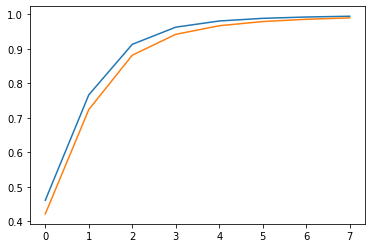

In [ ]:
# reset weights
gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

# plot two lines, one for Pr(real|real), one for Pr(real|fake)
probs_real = []
probs_fake = []

for cycle in range(8):
  print("Cycle", cycle)

  # First, optimize discriminator
  optimize_disc(steps=25)
  prob = prob_real_true(disc_weights).numpy()
  probs_real.append(prob)
  print("Prob(real classified as real): ", prob)
  

  # Second, optimize generator
  optimize_gen(steps=25)
  prob = prob_fake_true(gen_weights, disc_weights).numpy()
  probs_fake.append(prob)
  print("Prob(fake classified as real): ", prob)

plt.plot(probs_real)
plt.plot(probs_fake)

In a real scenario, we would have to fiddle more with the step size, number of steps, and number of cycles. However, as long as we can approach a probability of one for both the discriminator and generator, we will be satisfied with our resutls.